# Necassary Imports

In [1]:
# Imports
import gensim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

import re
#import inflect
#from num2words import num2words
from nltk.corpus import stopwords
from collections import Counter

import sklearn

from gensim.models import Word2Vec

from sklearn.model_selection import ParameterSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import RandomizedSearchCV

from nltk.stem import WordNetLemmatizer
import nltk 


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bvits\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\bvits\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bvits\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Necassary preprocessing steps

In [2]:
# Import data
df = pd.read_csv('us_equities_news_dataset.csv')

In [3]:
# Filter out Nvidia articles
nvidia_df = df[df['title'].str.contains('NVIDIA|NVDA', case=False, na=False) |
               df['content'].str.contains('NVIDIA|NVDA', case=False, na=False) |
               df['ticker'].str.contains('NVIDIA|NVDA', case=False, na=False)]

In [4]:
print(len(nvidia_df))

3464


In [5]:
#Pre processing steps
def preprocess_text_iteration1(text):
    text = text.strip()
    # Replace URLs with an empty string
    re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    words = word_tokenize(text.lower())
    #check if the word is alpha numeric
    alpha_words = [word for word in words if word.isalpha()]
    #remove numbers
    numbers_words = [word for word in alpha_words if not word.isdigit()]
    #stop words removal
    stop_words = set(stopwords.words('english'))
    numbers_words = [word for word in numbers_words if not word in stop_words]

    return numbers_words

# apply preprocessing
nvidia_df['content'] = nvidia_df['content'].apply(preprocess_text_iteration1)

C:\Users\bvits\AppData\Local\Temp\ipykernel_3892\721748992.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nvidia_df['content'] = nvidia_df['content'].apply(preprocess_text_iteration1)


In [6]:
#create a document term matrix
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(nvidia_df['content'].apply(lambda x: ' '.join(x)))
print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


[['nasdaq', 'stock', 'nyse', 'inc', 'nvidia', 'shares', 'stocks', 'day', 'nvda', 'trade'], ['nasdaq', 'nyse', 'trade', 'china', 'year', 'index', 'stocks', 'shares', 'earnings', 'percent'], ['zacks', 'earnings', 'year', 'stocks', 'company', 'growth', 'rank', 'stock', 'quarter', 'nasdaq'], ['market', 'said', 'one', 'could', 'companies', 'week', 'also', 'like', 'last', 'new'], ['year', 'company', 'nvidia', 'quarter', 'nasdaq', 'million', 'billion', 'zacks', 'revenues', 'intel']]
Topic 0: nasdaq stock nyse inc nvidia shares stocks day nvda trade
Topic 1: nasdaq nyse trade china year index stocks shares earnings percent
Topic 2: zacks earnings year stocks company growth rank stock quarter nasdaq
Topic 3: market said one could companies week also like last new
Topic 4: year company nvidia quarter nasdaq million billion zacks revenues intel
[[3.83954251e-01 1.23810528e-01 6.20982425e-04 4.90993420e-01
  6.20818388e-04]
 [5.40097998e-01 9.67432420e-03 7.56229474e-04 4.48702896e-01
  7.68552565

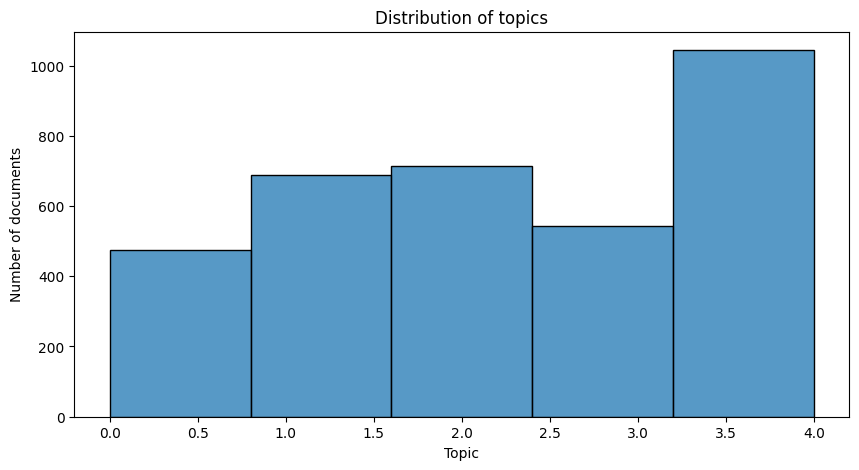

In [7]:
# train LDAModel
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(X)

# get topics
def get_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names_out()
    topics = []
    for topic in model.components_:
        topic_words = [words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append(topic_words)
    return topics

topics = get_topics(lda, vectorizer, 10)
print(topics)
for i, topic in enumerate(topics):
    print('Topic {}: {}'.format(i, ' '.join(topic)))


# get topic distribution for each document
topic_dist = lda.transform(X)
print(topic_dist)

# plot the distribution of topics
plt.figure(figsize=(10, 5))
sns.histplot(topic_dist.argmax(axis=1), bins=5)
plt.xlabel('Topic')
plt.ylabel('Number of documents')
plt.title('Distribution of topics')
plt.show()



In [8]:
# FuzzyTM FLSA-W
from FuzzyTM import FLSA_W

# Coherence and Diversity



In [9]:
# create a cluster plot for the topics

#if we have more time we look this because it is a cool plot (we don't fully understand it because copilot made it)

# from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2, random_state=0)
# tsne_embedding = tsne.fit_transform(topic_dist)
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=tsne_embedding[:, 0], y=tsne_embedding[:, 1], hue=topic_dist.argmax(axis=1), palette='tab10')
# plt.xlabel('t-SNE component 1')
# plt.ylabel('t-SNE component 2')
# plt.title('t-SNE plot of topics')
# plt.show()

## FLSA-W

In [10]:


# create a FLSA-W model
flsaW = FLSA_W(
input_file = nvidia_df['content'].to_list(),
num_topics=5,
num_words=10,
)

In [11]:
flsaW.get_vocabulary_size()
pwgt, ptgd = flsaW.get_matrices() # THIS TRAINS THE MODEL
print(flsaW.show_topics())


[(0, '0.0008*"traded" + 0.0007*"reuters" + 0.0007*"worst" + 0.0006*"previously" + 0.0006*"composite" + 0.0006*"ltd" + 0.0006*"lowest" + 0.0006*"donald" + 0.0006*"proven" + 0.0006*"sporting"'), (1, '0.0005*"gmt" + 0.0004*"outnumbered" + 0.0004*"performers" + 0.0003*"settle" + 0.0003*"slumped" + 0.0003*"gainers" + 0.0003*"dax" + 0.0003*"strategiesit" + 0.0003*"aug" + 0.0003*"advancers"'), (2, '0.0103*"book" + 0.0092*"evolution" + 0.0087*"books" + 0.0084*"richard" + 0.0075*"science" + 0.0069*"certainty" + 0.0066*"modern" + 0.0064*"professor" + 0.0053*"beliefs" + 0.0049*"mind"'), (3, '0.0017*"com" + 0.0017*"nvda" + 0.0017*"nvidia" + 0.0015*"intc" + 0.0015*"advanced" + 0.0015*"broader" + 0.0015*"nasdaq" + 0.0015*"rank" + 0.0015*"shares" + 0.0014*"believe"'), (4, '0.0002*"premarket" + 0.0002*"nasdaq" + 0.0002*"also" + 0.0002*"market" + 0.0002*"new" + 0.0002*"company" + 0.0002*"reiterates" + 0.0002*"one" + 0.0002*"time" + 0.0001*"cites"')]


In [12]:
for topic in flsaW.show_topics(representation='words'):
    print(topic)


print(flsaW.get_coherence_score()) # ask if this has to be high
print(flsaW.get_diversity_score()) # ask if this has to be high
print(flsaW.get_interpretability_score()) # ask if this has to be high




['traded', 'reuters', 'worst', 'previously', 'composite', 'ltd', 'lowest', 'donald', 'proven', 'sporting']
['gmt', 'outnumbered', 'performers', 'settle', 'slumped', 'gainers', 'dax', 'strategiesit', 'aug', 'advancers']
['book', 'evolution', 'books', 'richard', 'science', 'certainty', 'modern', 'professor', 'beliefs', 'mind']
['com', 'nvda', 'nvidia', 'intc', 'advanced', 'broader', 'nasdaq', 'rank', 'shares', 'believe']
['premarket', 'nasdaq', 'also', 'market', 'new', 'company', 'reiterates', 'one', 'time', 'cites']
0.46609810989969835
0.98
0.4567761477017044


In [13]:
#coherence for lda
print(
flsaW.get_coherence_score(
nvidia_df['content'].to_list(),
topics)
)


0.48413451396582863


In [14]:
#diversity for lda
print(flsaW.get_diversity_score(topics))

0.68


2
3
4
5
6
7
8
9
10


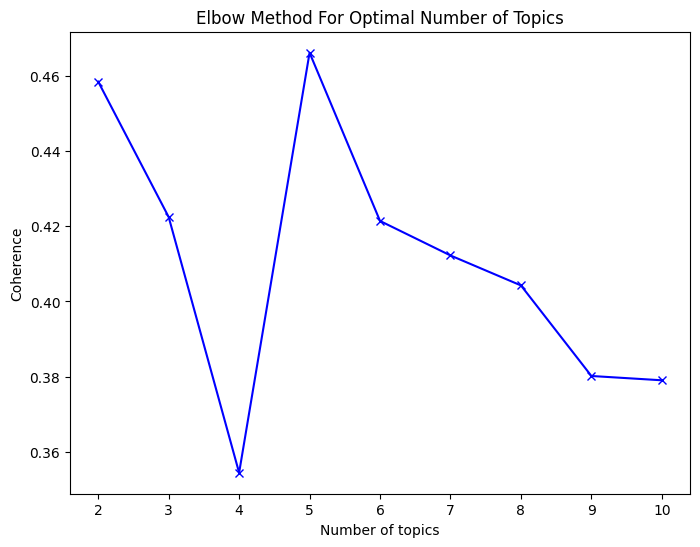

In [15]:
#elbow plot for FLSA-W
range_n_topics = range(1, 11)

# Create a list of coherence values
coherences = []
for n_topics in range_n_topics:
    print(n_topics)
    flsaW_elbow = FLSA_W(
    input_file = nvidia_df['content'].to_list(),
    num_topics=n_topics,
    num_words=10,
    )
    flsaW_elbow.get_vocabulary_size()
    pwgt, ptgd = flsaW_elbow.get_matrices() # THIS TRAINS THE MODEL
    coherence = flsaW_elbow.get_coherence_score()
    coherences.append(coherence)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, coherences, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Coherence')
plt.title('Elbow Method For Optimal Number of Topics')
plt.show()


In [ ]:
#elbow plot for diversity

#elbow plot for FLSA-W
range_n_topics = range(1, 11)

# Create a list of coherence values
diversities = []
for n_topics in range_n_topics:
    print(n_topics)
    flsaW_elbow = FLSA_W(
    input_file = nvidia_df['content'].to_list(),
    num_topics=n_topics,
    num_words=10,
    )
    flsaW_elbow.get_vocabulary_size()
    pwgt, ptgd = flsaW_elbow.get_matrices() # THIS TRAINS THE MODEL
    diversity = flsaW_elbow.get_diversity_score()
    coherences.append(diversity)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, coherences, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Diversity')
plt.title('Elbow Method For Optimal Number of Topics')
plt.show()


## Bert Topic

In [16]:
from bertopic import BERTopic
docs = [' '.join(doc) for doc in nvidia_df['content']]
# Create the model (uses DistilBERT by default)
bert_topic = BERTopic()
# Train the model and transform your data into topics
topic_assigned_to_doc, _ = bert_topic.fit_transform(docs)
topic_matrix = bert_topic.get_topic_info()
bert_topic.get_topics()



c:\Users\bvits\OneDrive\Desktop\2024\Uni\NLP\package install\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{-1: [('zacks', 0.008539482291943349),
  ('year', 0.008476085178202006),
  ('stocks', 0.008384405384490519),
  ('nasdaq', 0.008218684471276142),
  ('nvidia', 0.007661568669981134),
  ('market', 0.007658014331353199),
  ('company', 0.007617911200432746),
  ('earnings', 0.007402450919019819),
  ('growth', 0.007156071257685609),
  ('stock', 0.007010509401071385)],
 0: [('intel', 0.029367132287061226),
  ('ai', 0.01693541302603171),
  ('chips', 0.01178190654393498),
  ('qualcomm', 0.01069368766373725),
  ('data', 0.010279072835147096),
  ('technology', 0.009430871388308455),
  ('company', 0.009086495189582525),
  ('chip', 0.009058078511085524),
  ('nasdaq', 0.00826576946766116),
  ('google', 0.008225109247091324)],
 1: [('million', 0.02705017287021882),
  ('quarter', 0.02344270979997155),
  ('revenues', 0.02125503519329039),
  ('year', 0.020183508102775975),
  ('company', 0.01898210505671179),
  ('zacks', 0.018592862228935993),
  ('cents', 0.016652107256278866),
  ('estimate', 0.0148333445

In [17]:
print(topic_matrix)

    Topic  Count                                Name  \
0      -1   1039         -1_zacks_year_stocks_nasdaq   
1       0    171           0_intel_ai_chips_qualcomm   
2       1    161     1_million_quarter_revenues_year   
3       2    124           2_amd_graphics_radeon_gpu   
4       3     78  3_driving_self_vehicles_autonomous   
..    ...    ...                                 ...   
66     65     11   65_tsmc_smartphone_taiwan_percent   
67     66     11             66_losers_read_ndls_ttd   
68     67     11     67_google_alphabet_android_java   
69     68     11          68_traded_gmt_seven_lowest   
70     69     10   69_target_price_market_reiterated   

                                       Representation  \
0   [zacks, year, stocks, nasdaq, nvidia, market, ...   
1   [intel, ai, chips, qualcomm, data, technology,...   
2   [million, quarter, revenues, year, company, za...   
3   [amd, graphics, radeon, gpu, ryzen, processors...   
4   [driving, self, vehicles, autonomous, 

In [18]:
bert_topic.visualize_heatmap()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'coloraxis': 'coloraxis',
              'hovertemplate': 'x: %{x}<br>y: %{y}<br>Similarity Score: %{z}<extra></extra>',
              'name': '0',
              'type': 'heatmap',
              'x': [0_intel_ai_chips, 1_million_quarter_revenues,
                    2_amd_graphics_radeon, 3_driving_self_vehicles,
                    4_semiconductor_earnings_etf, 5_tracey_value_podcast,
                    6_target_nvidia_rating, 7_apple_iphone_year,
                    8_nvidia_nvda_stock, 9_resistance_roku_towards,
                    10_etf_tech_fund, 11_futures_et_points, 12_micron_dram_nand,
                    13_performers_close_inc, 14_nyse_dow_nasdaq,
                    15_trade_china_trump, 16_driving_self_autonomous,
                    17_walmart_might_earnings, 18_bitcoin_blockchain_crypt...,
                    19_gaming_quarter_year, 20_nvidia_ai_gaming,
                    21_facebook_users_user, 22_analyst_zacks_reports,
                    23_stock_nasdaq_investing, 24_day_trading_call,
                    25_might_week_market, 26_revenue_eps_com,
                    27_million_revenues_quarter, 28_percent_dollar_yield,
                    29_traded_gmt_seven, 30_china_trade_chinese,
                    31_inc_nyse_nasdaq, 32_estimize_earnings_quarter,
                    33_traded_gmt_seven, 34_semiconductor_china_chip,
                    35_cadence_design_ip, 36_resistance_around_level,
                    37_us_targets_scenario, 38_rtx_gaming_tracing,
                    39_earnings_greater_growth, 40_traded_gmt_seven,
                    41_qualcomm_commission_pate..., 42_huawei_china_chinese,
                    43_oil_crude_prices, 44_traded_gmt_seven,
                    45_mellanox_ethernet_switches, 46_traded_gmt_seven,
                    47_trader_today_editor, 48_traded_gmt_seven,
                    49_fed_yesterday_nyse, 50_earnings_shares_illumina,
                    51_percent_reuters_randewich, 52_rallied_australian_climbed,
                    53_performers_close_fell, 54_western_digital_storage,
                    55_games_stadia_gaming, 56_earnings_estimates_members,
                    57_oil_forecasts_sales, 58_investment_zacks_earnings,
                    59_instances_ai_cloud, 60_storage_pure_flashblade,
                    61_esports_game_video, 62_baidu_apollo_driving,
                    63_coronavirus_virus_china, 64_microsoft_azure_google,
                    65_tsmc_smartphone_taiwan, 66_losers_read_ndls,
                    67_google_alphabet_android, 68_traded_gmt_seven,
                    69_target_price_market],
              'xaxis': 'x',
              'y': [0_intel_ai_chips, 1_million_quarter_revenues,
                    2_amd_graphics_radeon, 3_driving_self_vehicles,
                    4_semiconductor_earnings_etf, 5_tracey_value_podcast,
                    6_target_nvidia_rating, 7_apple_iphone_year,
                    8_nvidia_nvda_stock, 9_resistance_roku_towards,
                    10_etf_tech_fund, 11_futures_et_points, 12_micron_dram_nand,
                    13_performers_close_inc, 14_nyse_dow_nasdaq,
                    15_trade_china_trump, 16_driving_self_autonomous,
                    17_walmart_might_earnings, 18_bitcoin_blockchain_crypt...,
                    19_gaming_quarter_year, 20_nvidia_ai_gaming,
                    21_facebook_users_user, 22_analyst_zacks_reports,
                    23_stock_nasdaq_investing, 24_day_trading_call,
                    25_might_week_market, 26_revenue_eps_com,
                    27_million_revenues_quarter, 28_percent_dollar_yield,
                    29_traded_gmt_seven, 30_china_trade_chinese,
                    31_inc_nyse_nasdaq, 32_estimize_earnings_quarter,
                    33_traded_gmt_seven, 34_semiconductor_china_chip,
                    35_cadence_design_ip, 36_resistance_around_level,
                    37_us_targets_scenario, 38_rtx_gaming_tracing,
                  

In [19]:
topic_matrix.head(10)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1039,-1_zacks_year_stocks_nasdaq,"[zacks, year, stocks, nasdaq, nvidia, market, ...",[immediate release chicago il march highlights...
1,0,171,0_intel_ai_chips_qualcomm,"[intel, ai, chips, qualcomm, data, technology,...",[intel corporation nasdaq intc gearing become ...
2,1,161,1_million_quarter_revenues_year,"[million, quarter, revenues, year, company, za...",[keeping positive surprise history alive proof...
3,2,124,2_amd_graphics_radeon_gpu,"[amd, graphics, radeon, gpu, ryzen, processors...",[month since last earnings report advanced mic...
4,3,78,3_driving_self_vehicles_autonomous,"[driving, self, vehicles, autonomous, car, car...",[intel corporation nasdaq intc recent deal win...
5,4,77,4_semiconductor_earnings_etf_industry,"[semiconductor, earnings, etf, industry, score...",[semiconductor stocks tear year improved overs...
6,5,70,5_tracey_value_podcast_stocks,"[tracey, value, podcast, stocks, investment, z...",[immediate releasechicago il april zacks marke...
7,6,67,6_target_nvidia_rating_price,"[target, nvidia, rating, price, previously, ra...",[nvidia nasdaq nvda reported results yesterday...
8,7,63,7_apple_iphone_year_billion,"[apple, iphone, year, billion, services, zacks...",[earnings season heats wall street watching ap...
9,8,56,8_nvidia_nvda_stock_earnings,"[nvidia, nvda, stock, earnings, investors, gam...",[shares nvidia nasdaq nvda climbed roughly far...


In [20]:
# print the name of the topic matrix and the representative docs using for loop
for i in range(0, 11):
    print(topic_matrix['Name'][i])
    print(topic_matrix['Representative_Docs'][i])
    print('')

-1_zacks_year_stocks_nasdaq
['immediate release chicago il march highlights weight watchers international inc nyse wtw bull day tutor perini corporation nyse tpc bear day addition zacks equity research provides analysis nvidia corporation nasdaq nvda micron technology nasdaq mu synopsis four stocks weight watchers international inc managed completely turn around business last years zacks rank strong buy one industry leaders weight loss wellness weight watchers wellness company operates weight management programs web site meetings another beat fourth quarteron feb weight watchers reported fourth quarter results beat zacks consensus cents earnings versus zacks consensus estimate earnings beat row revenue rose quarter million full year revenue gained year year billion also continued add subscribers quick pace rose year year fourth quarter million subscribers total paid weeks also rose quarter year year full year company said saw strong response launch ww freestyle program december strong 

In [21]:
#create a list of the first 10 representative docs
rep_docs = topic_matrix['Representation'][1:6].to_list()
print(rep_docs)




[['intel', 'ai', 'chips', 'qualcomm', 'data', 'technology', 'company', 'chip', 'nasdaq', 'google'], ['million', 'quarter', 'revenues', 'year', 'company', 'zacks', 'cents', 'estimate', 'consensus', 'rank'], ['amd', 'graphics', 'radeon', 'gpu', 'ryzen', 'processors', 'epyc', 'micro', 'year', 'intel'], ['driving', 'self', 'vehicles', 'autonomous', 'car', 'cars', 'vehicle', 'tesla', 'mobileye', 'said'], ['semiconductor', 'earnings', 'etf', 'industry', 'score', 'zacks', 'semiconductors', 'rank', 'beta', 'stock']]


In [22]:
#bert coherence --> just say we tried, in the end it doesn't matter I tried hard and got so far 
print(
flsaW.get_coherence_score(
nvidia_df['content'].to_list(),
rep_docs)
)


0.6916317954745355


In [23]:
#bert diversity
print(flsaW.get_diversity_score(rep_docs))

0.9


topic